# CAP 394-1 - Introdução à Data Science
### Eduardo Pereira de Sousa
## Tema: Decomposição de Software por meio do Acoplamento Semântico

A qualidade de um software pode ser medida por diferentes pontos de vista, dentre esses, a análise de métricas do código-fonte é um dos mais relevantes ao processo de desenvolvimento e manutenção.

Essas métricas expressam diferentes características do código-fonte, no caso de softwares orientados à objeto é comum o uso das métricas propostas por _Chidamber e Kemerer_, como: número de métodos por classe, acoplamento entre classes e coesão entre métodos de uma classe.

Essas métricas servem de base para diversas ferramentas e métodos de análise, como os _bad smells_, que são características de classes e métodos que podem indicar a ocorrência de problemas mais graves nesses componentes. Uma classe possui um determinado _bad smell_ caso suas métricas ultrapassem um conjunto pré-definido de limiares.

_Aniche et al._ mostrou que esses limiares podem ser mais eficientes na identificação dos _bad smells_ caso se considere o papel do componente na arquitetura do software na definição dos limiares sob os quais cada classe será avaliada.

A definição do papel arquitetural de uma determinada classe frente ao software que ela compõe é por si só uma questão em aberto, visto que o método aplicado por _Aniche et al._ baseia-se em características próprias dos _frameworks_ Spring MVC e Android, as quais não podem ser aplicadas de forma geral a outros softwares, ainda que desenvolvidos na mesma linguagem.

Nesse ponto, o trabalho de _Bavota et al._ evidencia um possível caminho na decomposição de sistemas de software por meio do acoplamento semântico de seus componentes. Seu trabalho aponta que o acoplamento semântico é aquele capaz de expressar com maior fidelidade a percepção dos próprios desenvolvedores, quando comparado a outros métodos de análise do acoplamento. O acoplamento semântico utiliza a similaridade do vocabulário de classes e métodos como forma de evidenciar as relações entre esses componentes.

Neste trabalho, exploraremos diferentes metodologias e técnicas para obtenção, visualização e análise do vocabulário, comparando essas abordagens quanto a capacidade de recuperar a decomposição original da aplicação em pacotes e segundo o método originalmente usado por Aniche et al. na análise de projetos desenvolvidos com o framework Spring MVC. Nosso objetivo é explorar e verificar o comportamento e os resultados obtidos com diferentes abordagens, além de explorar técnicas que permitam a visualização dos dados obtidos.


### Bibliografia

Aniche, M., Treude, C., Zaidman, A., Van Deursen, A., & Gerosa, M. A. (2016, October). SATT: Tailoring code metric thresholds for different software architectures. In Source Code Analysis and Manipulation (SCAM), 2016 IEEE 16th International Working Conference on (pp. 41-50). IEEE.

Bavota, G., Dit, B., Oliveto, R., Di Penta, M., Poshyvanyk, D., & De Lucia, A. (2013, May). An empirical study on the developers' perception of software coupling. In Proceedings of the 2013 International Conference on Software Engineering (pp. 692-701). IEEE Press.

Chidamber, S. R., & Kemerer, C. F. (1994). A metrics suite for object oriented design. IEEE Transactions on software engineering, 20(6), 476-493.

Poshyvanyk, D., Marcus, A., Ferenc, R., & Gyimóthy, T. (2009). Using information retrieval based coupling measures for impact analysis. Empirical software engineering, 14(1), 5-32.

## Clone GitHub Repository

In [1]:
import os
from git import Repo

In [2]:
# Set the project to be retrieved
project_org = 'spring-projects'
project_name = 'spring-petclinic'
# Where to store the repository locally
local_path = os.path.join('./repositories', project_org, project_name)
# From where to grab the repository
github_url = 'https://github.com/{}/{}.git'.format(project_org, project_name)

In [3]:
# Clone the repository
try:
    Repo.clone_from(github_url, local_path, depth=1)
except:
    print('repository already exists')

repository already exists


## Extract Corpus from Java Source Code

In [4]:
from sklearn.datasets.base import Bunch
import javalang
import glob
import io

In [5]:
tokens_to_grab = [javalang.tokenizer.Identifier]

In [6]:
def extract_corpus(token_list, after_line):
    corpus = []
    line_words = []
    line_number = 0
    for token in token_list:
        token_line = token.position[0]
        if token_line < after_line:
            continue
        if token_line > line_number:
            line_number = token_line
            if len(line_words) > 0:
                corpus.append(' '.join(line_words))
                line_words = []
        if type(token) in tokens_to_grab:
            line_words.append(token.value.strip())
    if len(line_words) > 0:
        corpus.append(' '.join(line_words))
    return '\n'.join(corpus)

def get_source_code(filename):
    f = io.open(filename, 'r', encoding="utf-8")
    source_code = f.read()
    f.close()
    return source_code

def in_project_path(project_path, file_path):
    return file_path[len(project_path):]

def get_project_corpus(project_path):
    data = []
    path = []
    for filename in glob.iglob(project_path + "/**/*.java", recursive=True):
        source_code = get_source_code(filename)
        try:
            ast = javalang.parse.parse(source_code)
            if len(ast.types) == 0:
                break
            start_line = ast.types[0].position[0]
            token_list = list(javalang.tokenizer.tokenize(source_code))
            path.append(in_project_path(project_path, filename))
            data.append(extract_corpus(token_list, start_line))
        except javalang.parser.JavaSyntaxError as e:
            print("Syntax error parsing {}".format(filename))
    
    return Bunch(data=data,
                path=path)

corpus = get_project_corpus(local_path)

In [7]:
print(corpus.path[15])
print(corpus.data[15])

/src/main/java/org/springframework/samples/petclinic/owner/VisitController.java
VisitController
VisitRepository visits
PetRepository pets
VisitController VisitRepository visits PetRepository pets
visits visits
pets pets
InitBinder
setAllowedFields WebDataBinder dataBinder
dataBinder setDisallowedFields
ModelAttribute
Visit loadPetWithVisit PathVariable petId Map String Object model
Pet pet pets findById petId
model put pet
Visit visit Visit
pet addVisit visit
visit
GetMapping
String initNewVisitForm PathVariable petId Map String Object model
PostMapping
String processNewVisitForm Valid Visit visit BindingResult result
result hasErrors
visits save visit


## WordCloud

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

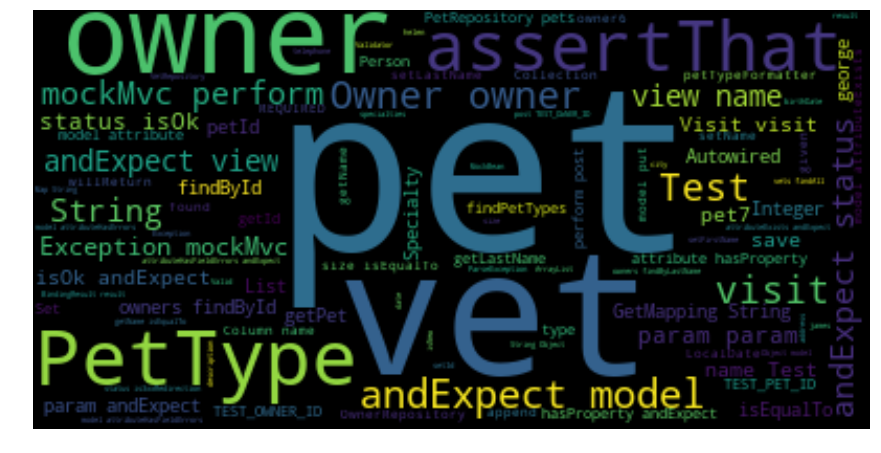

In [9]:
plt.rcParams['figure.figsize'] = [15, 10]
wc = wordcloud = WordCloud().generate(' '.join(corpus.data))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Text Vectorizing

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [11]:
# Create sparse matrix of word counts
count_vectorizer = CountVectorizer(analyzer='word', min_df = 0)
count_matrix = count_vectorizer.fit_transform(corpus.data)
# Transform count to frequency (TF/IDF)
tf_transformer = TfidfTransformer(use_idf=True)
freq_matrix =  tf_transformer.fit_transform(count_matrix)

In [12]:
sum_words = freq_matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
for word, freq in words_freq:
    print(word, freq)

andexpect 2.7739621587807353
vets 2.5587951543631258
pet 2.5553474385854362
owner 2.374378251801631
visit 2.0949256463635186
pettype 2.0614823767472723
string 2.040657706742877
vet 1.9327797936126412
pets 1.5857675142839431
mockmvc 1.491814149502341
integer 1.4198894873724832
namedentity 1.3960323724509525
model 1.3939143819930098
name 1.3201675428292508
test 1.1891906031374861
specialty 1.1835170212417636
getmapping 1.1537196930848004
param 1.1285707715431244
transactional 1.0331195772458788
readonly 1.0241557186821764
exception 0.9895868221903519
list 0.9710085589971
visits 0.9159222918566893
assertthat 0.9097331645085899
findall 0.8924364722305357
status 0.8533018677599351
perform 0.8533018677599351
petid 0.8490263754247696
owners 0.8441781313628894
repository 0.8186802185559836
isequalto 0.7676301817240612
view 0.7435848375559626
save 0.7259297517834632
isok 0.678708841766622
person 0.6742434628356265
vetrepository 0.6692641243796746
collection 0.6682881331008061
pettypeformatter 0

## Similarities

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = cosine_similarity(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

def most_similar(tfidf_matrix, index):
    return find_similar(tfidf_matrix, index, 1)[0]

In [14]:
for index, path in enumerate(corpus.path):
    most_similar_index, score = most_similar(freq_matrix, index)
    print('{} is {:.2f}% similar to {}'.format(path[53:], score*100, corpus.path[most_similar_index][53:]))

PetclinicIntegrationTests.java is 68.17% similar to vet/VetController.java
service/EntityUtils.java is 3.22% similar to service/ClinicServiceTests.java
service/ClinicServiceTests.java is 34.10% similar to owner/PetController.java
owner/PetControllerTests.java is 82.49% similar to owner/OwnerControllerTests.java
owner/PetTypeFormatterTests.java is 58.42% similar to owner/PetTypeFormatter.java
owner/OwnerControllerTests.java is 82.49% similar to owner/PetControllerTests.java
owner/VisitControllerTests.java is 82.39% similar to owner/PetControllerTests.java
system/CrashControllerTests.java is 70.14% similar to owner/PetControllerTests.java
vet/VetTests.java is 38.30% similar to vet/VetRepository.java
vet/VetControllerTests.java is 52.92% similar to system/CrashControllerTests.java
model/ValidatorTests.java is 18.74% similar to service/ClinicServiceTests.java
PetClinicApplication.java is 4.07% similar to owner/Owner.java
owner/OwnerController.java is 51.26% similar to owner/PetController.j

## Clustering

In [15]:
from sklearn.cluster import KMeans

In [22]:
number_of_clusters = 5
km = KMeans(n_clusters=number_of_clusters,init='k-means++', max_iter=100, n_init=1)
km.fit(freq_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
for i, c in enumerate(km.labels_):
    print(c, corpus.path[i][53:])

3 PetclinicIntegrationTests.java
0 service/EntityUtils.java
0 service/ClinicServiceTests.java
1 owner/PetControllerTests.java
2 owner/PetTypeFormatterTests.java
1 owner/OwnerControllerTests.java
1 owner/VisitControllerTests.java
1 system/CrashControllerTests.java
0 vet/VetTests.java
1 vet/VetControllerTests.java
0 model/ValidatorTests.java
0 PetClinicApplication.java
0 owner/OwnerController.java
2 owner/PetType.java
4 owner/PetTypeFormatter.java
4 owner/VisitController.java
2 owner/Owner.java
2 owner/PetValidator.java
2 owner/PetRepository.java
0 owner/PetController.java
2 owner/OwnerRepository.java
4 owner/Pet.java
4 visit/Visit.java
4 visit/VisitRepository.java
0 system/CrashController.java
0 system/WelcomeController.java
4 system/CacheConfiguration.java
3 vet/VetController.java
2 vet/Specialty.java
3 vet/Vets.java
2 vet/Vet.java
2 vet/VetRepository.java


In [18]:
print("Termos mais comuns por cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = count_vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Termos mais comuns por cluster:
Cluster 0: pet owner string getmapping pets
Cluster 1: vets vet findall vetrepository other
Cluster 2: andexpect mockmvc status perform param
Cluster 3: visit cacheconfiguration date petid integer
Cluster 4: pettype pettypeformatter locale entity person
Cluster 5: namedentity specialty serializable pettype specialties
